# *Optical Tweezers* | Lab-Session #8
## Feb-22-2021 14:42

This jupyter notebook is a used to collect and analyse data from Monday, Feb 22nd.
The data used is time series of a trapped bead. The voltage QPD signal is converted to position data using info from LAB 6&7. Then the trap stiffness and drag coefficient are found using three methods: PSD fitting, potential fitting and equipartition theorem.

### About this notebook: how to
- Run cells to define functions
- Run <a href='#load_data'>this cell</a> to load data
- Run <a href='#main'>this cell</a> to generate plots

### Algorithm:
- 1. [Load data from directory](#load_data)<br>
- 2. [Choose which data sets to run](#main)<br>
- 3. [Import and prepare calibration matrices](#calibration)<br>
- 4. For each chosen dataset:<br>
    - 4.1. [Initiate figures](#main)<br>
    - 4.2. [Get data and load in arrays](#get_data)<br>
    - 4.3. [Initiate empty arrays for data storage](#init_list)<br>
    - 4.4. [Convert QPD voltage into position w/ cal matrices](#main)<br>
    - 4.5. [Find laser power, choose position or voltage mode, choose time frame for position plots](#main)<br>
    - 4.5. [Plot the position data](#plotting)<br>
    - 4.6. [Generate periodogram](#main)<br>
    - 4.7. [Rescale data](#PSD_gen)<br>
    - 4.8. [Find moving average](#PSD_gen)<br>
    - 4.9. [Plot the power spectrum](#plotting)<br>
    - 4.10. [Fit the power spectrum](#PSD_fit)<br>
    - 4.11. [Construct the energy histogram](#Energy_construct)<br>
    - 4.12. [Fit the potential energy](#fit_energy)<br>
    - 4.13. [Plot potential energy](#plotting)<br>
    - 4.14. [Save_fig](#main)<br>
- 5. [Equipartition theorem method](#equi)<br>
- 6. [Save data](#export_data)<br>


# Data Collection

Data were collected for the calibration of the optical trap, by trapping a bead and plotting the power spectrum of each coordinate.

In [13]:
# Import the relevant libraries
import pandas as pd
import numpy as np 
import matplotlib.pyplot as plt 
import scipy.constants as const
from scipy import interpolate
import scipy.signal
import os
from csvlib import *
from scipy.optimize import curve_fit
from IPython.display import display
from PIL import Image
from tqdm import tqdm
import csv
import matplotlib.gridspec as gridspec

# Display mpl in notebook format
%matplotlib inline

<a id='export_data'></a>

In [14]:
# SAVING DATA functions

def InitiateFilesV():
    #creates blank csv files to save data in 
    
    # files with Voltage fitting
    coord_V = ['x','y','z']
    for i in range(0,len(coord_V)):
        with open('free_bead_data_V_'+coord_V[i]+'.csv', mode='w') as free_bead_data:
            initiate = csv.writer(free_bead_data, delimiter=',', quotechar='"', quoting=csv.QUOTE_MINIMAL)

            initiate.writerow(['Laser Intensity (mA)', 'k_equipartition', 'err_k_eq','k_potential','err_k_potential',
                               'PSD_I_k','PSD_II_drag','PSD_II_k_b','PSD_II_f0','PSD_II_k',
                               'PSD_III_f0','PSD_III_k','PSD_III_drag'])
    return

def InitiateFilesPos():
    # creates blank csv files to save data in
    
    # files with position fitting
    coord_pos = ['x','y']
    for i in range (0,len(coord_pos)):
        with open('free_bead_data_pos_'+coord_pos[i]+'.csv', mode='w') as free_bead_data:
            initiate = csv.writer(free_bead_data, delimiter=',', quotechar='"', quoting=csv.QUOTE_MINIMAL)

            initiate.writerow(['Laser Intensity (mA)',
                               'k_equipartition', 'err_k_eq','k_potential','err_k_potential','err_k_cov',
                               'PSD_I_k','err_PSD_I_k','PSD_II_drag','err_PSD_II_drag','PSD_II_k_b','err_PSD_II_k_b',
                               'PSD_II_f0','err_PSD_II_f0','PSD_II_k','err_PSD_II_k','PSD_III_f0','err_PSD_III_f0',
                               'PSD_III_k','err_PSD_III_k','PSD_III_drag','err_PSD_III_drag'])
            
    return

def SaveFittedPos(laser,k_equi,err_k_equi,k_potential,err_k_potential,err_k_cov,PSD_I_k,err_PSD_I_k,
                  PSD_II_drag,err_PSD_II_drag,PSD_II_k_b,err_PSD_II_k_b,
                  PSD_II_f0,err_PSD_II_f0,PSD_II_k,err_PSD_II_k,PSD_III_f0,err_PSD_III_f0,PSD_III_k,
                  err_PSD_III_k,PSD_III_drag,err_PSD_III_drag):
    
    labels_pos = ['x','y']

    for i in range(0,len(labels_pos)):
        with open('free_bead_data_pos_'+labels_pos[i]+'.csv', mode='a') as free_bead_data_x:
            save_data = csv.writer(free_bead_data_x, delimiter=',', quotechar='"', quoting=csv.QUOTE_MINIMAL)
            
            save_data.writerow([laser,k_equi[i],err_k_equi[i],k_potential[i],err_k_potential[i],err_k_cov[i],
                                PSD_I_k[i],err_PSD_I_k[i],
                                PSD_II_drag[i],err_PSD_II_drag[i],PSD_II_k_b[i],err_PSD_II_k_b[i],
                                PSD_II_f0[i],err_PSD_II_f0[i],PSD_II_k[i],err_PSD_II_k[i],
                                PSD_III_f0[i],err_PSD_III_f0[i],PSD_III_k[i],err_PSD_III_k[i],
                                PSD_III_drag[i],err_PSD_III_drag[i]])
                                

# Section: function definitions

<a id='get_data'></a>

In [15]:
# read DATA from selected file 

def readDATA(indx=1,centerData='True',printCSV=False):
    
    # This function imports the data from a selected .csv file
    # input: index of file to be read
    # output: time and position data, laser power and file name

    # open CSV files to numpy array
    csvs = list_csv(directory='.',PRINT=printCSV)   # Lists CSV files in a given directory

    DATA = pd.read_csv(csvs[indx])  # Gets the CSV file as a Pandas Data Frame

    data = DATA.to_numpy().T        # Gets data as a numpy array
    # DATA                            # Prints pretty PANDAS data frame

    ########################################### Getting data from file

    ## Store the different variables
    t = np.linspace(0,5,500000)

    if centerData: 
        # centering data around 0
        # by subtracting average
        
        x = data[0]-sum(data[0])/len(data[0])
        y = data[1]-sum(data[1])/len(data[1])
        z = data[2]-sum(data[2])/len(data[2])

    # finds laser power
    laser = float(csvs[indx].split('_')[2][:3])
    
    return t,x,y,z,laser,csvs[indx]


<a id='calibration'></a>

In [16]:
# generate calibration matrices

def ImportQPDCal():
    
    # This function imports the QPD calibration data [x,y]
    # from the .txt files in the directory
    # input: laser power of current data 
    # 
    
    # assuming V_QPD and V_stage reading has neglible error

    # X_stage = cal_QPD [coordinate][laser_indx] * V_QPD
    # X_stage_err = err_QPD [coordinate][laser_indx] * V_QPD

    # V_stage = alpha * V_QPD
    # X_stage = beta * V_stage

    # from LAB 7
    CAL_X = pd.read_csv('cal-stg-qpd-x.txt',skip_blank_lines=True,comment='#')
    CAL_Y = pd.read_csv('cal-stg-qpd-y.txt',skip_blank_lines=True,comment='#')

    # V_stage = cal_alpha[coordinate][laser_indx] * V_QPD
    cal_alpha = np.array([CAL_X.to_numpy().T[0],CAL_Y.to_numpy().T[0]])
    err_alpha = np.array([CAL_X.to_numpy().T[1],CAL_Y.to_numpy().T[1]])
    laser_intensity = CAL_X.to_numpy().T[2].tolist()

    # from LAB 6
    cal_beta = np.array([1.746e-06,1.776e-06])
    err_beta = np.array([0.009e-06,0.047e-06])

    #cal_QPD = np.array([np.repeat(0,len(laser_intensity)),np.repeat(0,len(laser_intensity))])
    #err_QPD = np.array([np.repeat(0,len(laser_intensity)),np.repeat(0,len(laser_intensity))])

    # construct calibration arrays
    cal_QPD = []
    err_QPD = []

    for i in range(2):
        cal_QPD.append(cal_alpha[i]*cal_beta[i])
        err_QPD.append(np.sqrt((cal_alpha[i]*err_beta[i])**2+(cal_beta[i]*err_beta[i])**2))
    
    return cal_QPD,err_QPD,cal_alpha,err_alpha,cal_beta,err_beta,laser_intensity


<a id='init_list'></a>

In [17]:
def InitiateLists(num=0):
    mylist=[]
    for i in range(0,num):
        mylist.append([])
    
    return mylist

<a id='plotting'></a>

In [18]:
# plotting functions
sz_title = 12
sz_label = 10
sz_legend = 8

def PlotPosition(ax,file,label,color,t,x,start,end,laser,title=True):
    
    ####################################### plotting POSITION
    
    if file=='position':
     
        if title: ax.set_title('Laser Intensity: '+str(laser)+'mA\n'+'Position over time',fontsize=sz_title)

        ax.set_xlabel(r'Time $t\ [s]$',fontsize=sz_label)
        ax.set_ylabel('Position ' + label + r' $ [\mu m]$',fontsize=sz_label,labelpad=0.1)

        ax.plot(t,x*1e6,c=color)
        
    else:
        
        if title: ax.set_title('Voltage over time\n'+'Intensity: '+str(laser)+'mA\n',fontsize=sz_title)

        ax.set_xlabel(r'Time $t\ [s]$',fontsize=sz_label)
        ax.set_ylabel('Voltage ' + label + r' $ [V]$',fontsize=sz_label,labelpad=0.4)

        ax.plot(t,x,c=color)
    
    ax.grid()
    ax.set_xlim(start,end)
    
    return

def PlotPSD(ax,label,color,f_plot,pxx_plot,f_fit,pxx_fit,laser):
    ax.set_title('Power Spectrum Density along '+label,fontsize=sz_title)
    
    ax.set_xlabel(r'Frequency $f\ [Hz]$',fontsize=sz_label)
    ax.set_ylabel('PSD ' + label + r' $ [m^2/Hz]$',fontsize=sz_label)
    ax.grid()
        
    ax.plot(f_plot,pxx_plot,'.',c=color,ms=1,alpha=0.05)
    ax.plot(f_fit,pxx_fit,c=color,ms=0.3,label='Dataset to be fitted')
    
    ax.set_xscale('log')
    ax.set_yscale('log')
    ax.grid(False)
        
    return

def PlotEnergy(ax,label,color,xx,E):
    
    # Adding the necessary plot elements
    ax.set_title('Potential Energy on '+label,fontsize=sz_title)
    ax.set_xlabel('Displacement '+label+r' $\ [m]$',fontsize=sz_label)
    ax.set_ylabel('Potential Energy ' + label + r' $ [J]$',fontsize=sz_label,labelpad=12)
    ax.grid()
    
    # Plot the potential energy
    ax.plot(xx,E,c=color)
    ax.grid(False)
    
    return 
    

### Power spectrum and Boltzmann's distribution analysis
Plotting time series from QPD output. Calculating PSD and fitting. Calclating potential energy from Boltzmann's distribution and fitting.

QPD voltage in x and y directions is converted to position values using the conversion factors generated in LAB 7.

<a id='PSD_gen'></a>

In [19]:
def PSD_Rescale(f,pxx,sample_size):
    
    # rescales the PSD spectrum so that
    # in a log-log plot, data is equally distributed along x
    
    spl = interpolate.splrep(f, pxx)
    f_new = np.exp(np.linspace(np.log(f[1]), np.log(f[-1]), sample_size))
    pxx_new = interpolate.splev(f_new, spl)
    
    return f_new, pxx_new

def PSD_Moving_Average(f_new,pxx_new):
    total = len(pxx_new)
    window = int(total*0.005)

    pxx_avg = np.zeros(total-window)

    for k in range (total-window):
        pxx_avg[k] = np.sum(pxx_new[k:k+window])/window

    f_avg = f_new[:total-window]
    
    return f_avg, pxx_avg

<a id='Energy_construct'></a>

In [20]:
def Energy_construct(data,Nbins):
    
    # Obtaining the histogram of the data
    hist, xx = np.histogram(data,bins=Nbins)
    xx = np.array([(xx[i]+xx[i+1])/2 for i in range(len(xx)-1)])
    
    # Finding energy
    E = -const.k*T*np.log(hist)
    
    return xx,E

<a id='PSD_fit'></a>

In [21]:
def PSDI_Plot_Fit(ax,bounds,f_fit,pxx_fit,alpha_0,f_plot,pxx_plot,plot=True):
    # Sxx: one fit parameter - trap stiffness
    # assumes theoretical drag coefficient
    # 
    # fits the data with initial choice or bounds of parameters
    # adds computed parameters and errors to the lists
    # plots the fit
    
    SxxI = lambda f,alpha: (const.k*T)/(np.pi**2 * beta*(f**2 + (alpha/(2*np.pi*beta))**2))
    
    #alpha_trap = 0.5e-7
    
    # fitting
    if bounds: 
        params, pcov = curve_fit(SxxI,f_fit,pxx_fit,bounds=((alpha_0[0]),(alpha_0[1])),maxfev=1000) 
    else:
        params, pcov = curve_fit(SxxI,f_fit,pxx_fit,p0=[alpha_0],maxfev=1000)
    
    PSD_I_k.append(params[0])
    err_PSD_I_k.append(np.sqrt(pcov[0]))
    
    #assumes theoretical drag
        
    # Plot the fit
    if plot:
        ax.plot(f_plot,SxxI(f_plot,*params),c='k',
                label='\n'+r'$f_0 = %1.3e \pm %1.3e$'%(params[0]/(2*np.pi*beta),np.sqrt(pcov[0]))+
                '\n'+r'$\alpha = %1.3e \pm %1.3e$'%(params[0],np.sqrt(pcov[0]))+
                '\n')
    #ax.legend()
    
    return

def PSDII_Plot_Fit(ax,bounds,f_fit,pxx_fit,f_0,A_0,f_plot,pxx_plot,plot=True):
    
    # SxxII: two fit parameters - the cutoff frequency f0 and parameter A0
    # Calculates: 
    #            Boltzmann's constant using theoretical drag
    #            Drag coefficient from A0 fit
    #            Trap stiffness from f0 fit and exp drag coeff
    
    # fits the data with initial choice or bounds of parameters
    # adds computed parameters and errors to the lists
    # plots the fit
    
    SxxII = lambda f,f_0,alpha: alpha/(f**2+f_0**2)
    
    # fitting
    if bounds: 
        params, pcov = curve_fit(SxxII,f_fit,pxx_fit,bounds=((f_0[0],A_0[0]),(f_0[1],A_0[1])),maxfev=1000) 
    else:
        params, pcov = curve_fit(SxxII,f_fit,pxx_fit,p0=[f_0,A_0],maxfev=1000)
        #A_0 = 1e-3*(const.k*T/(np.pi**2*3*np.pi*eta*d))
    #f_0 = 1e2
    
    # fitted parameters
    f0 = abs(params[0])
    A0 = params[1]
    
    # errors on parameters from fitting 
    err_f0 = np.sqrt(pcov[0][0])
    err_A0 = np.sqrt(pcov[1][1])
    
    # Boltzmann's constant
    k_b_th = A0*(np.pi**2*3*np.pi*eta*d)/T
    err_k_b = err_A0*(np.pi**2*3*np.pi*eta*d)/T
    
    # Drag coefficient
    beta_fit = const.k*T/(np.pi**2*A0)
    err_beta_fit = beta_fit * err_A0/A0

    # alpha using theoretical drag
    alpha_th = f0*(2*np.pi**2*3*eta*d)
    
    # alpha using experimental drag
    alpha_exp = f0*(2*np.pi*beta_fit)
    err_alpha_exp = np.sqrt((err_f0*(2*np.pi*beta_fit))**2+(alpha_exp*err_beta_fit/beta_fit)**2)
        
    PSD_II_drag.append(beta_fit)
    PSD_II_k_b.append(k_b_th)
    PSD_II_f0.append(f0)
    PSD_II_k.append(alpha_exp)
        
    err_PSD_II_drag.append(err_beta_fit)
    err_PSD_II_k_b.append(err_k_b)
    err_PSD_II_f0.append(err_f0)
    err_PSD_II_k.append(err_alpha_exp)
            
    # Plot the fit
    if plot:
        ax.plot(f_plot,SxxII(f_plot,*params),c='g',
                label=r'$f_0 = %1.3e \pm %1.3e$'%(f0,err_f0)+
                        '\n'+r'$k_{trap} = %1.3e \pm %1.3e$'%(alpha_exp,err_alpha_exp)+
                        '\n'+r'$K_b = %1.3e \pm %1.3e$'%(k_b_th,err_A0)+
                        '\n'+r'$\gamma = %1.3e \pm% 1.3e$'%(beta_fit,err_beta_fit)
                        #+'\n'+r'$A_0 = %1.3e$'%(A0)
               
    #ax.legend()
    ax.plot(f_plot,SxxII(f_plot,[f_0,alpha]),c='red')
    
    return

def PSDIII_Plot_Fit(ax,bounds,f_fit,pxx_fit,f_0,alpha_0,f_plot,pxx_plot,plot=True):
    
    # SxxIII: two fit parameters - cutoff frequency f0 and trap stiffness alpha_trap
    # Calculates:
    #            Drag coefficient from f0 and alpha_trap fits
    #            Viscosity from experimental drag
    
    # fits the data with initial choice or bounds of parameters
    # adds computed parameters and errors to the lists
    # plots the fit
    
    SxxIII = lambda f,f_0,alpha: (2.*const.k*T*f_0)/(np.pi*alpha*(f**2+f_0**2))
    
    if bounds:
        params, pcov = curve_fit(SxxIII,f_fit,pxx_fit,bounds=((f_0[0],alpha_0[0]),(f_0[1],alpha_0[1])),maxfev=1000)   
        # f_0 = [80,130]
        # alpha_0 = [5e-06],5e-05]
    
    else:
        params, pcov = curve_fit(SxxIII,f_fit,pxx_fit,p0=[f_0,alpha_0],maxfev=1000)
        #f_0 = 70
        #alpha_trap = 0.5e-4
    
    # found parameters
    f0 = abs(params[0])
    alpha_trap = params[1]
    
    # found errors
    err_f0 = np.sqrt(pcov[0][0])
    err_alpha_trap = np.sqrt(pcov[1][1])
    
    # computing drag coefficient from the fits
    beta_exp = alpha_trap/(2*np.pi*f0)
    err_beta_exp = np.sqrt((err_alpha_trap/(2*np.pi*f0))**2+(beta_exp*err_f0/f0)**2)
    
    # computing the viscosity
    eta = beta_exp / (3*d*np.pi)
        
    PSD_III_f0.append(f0)
    err_PSD_III_f0.append(err_f0)
    
    PSD_III_k.append(alpha_trap)
    err_PSD_III_k.append(err_alpha_trap)
    
    PSD_III_drag.append(beta_exp)
    err_PSD_III_drag.append(err_beta_exp)
        
    # Plot the fit
    if plot:
        ax.plot(f_plot,SxxIII(f_plot,*params),c='c',
                label='\n'+r'$f_0 = %1.3e \pm %1.3e$'%(f0,err_f0)+
                '\n'+r'$\alpha_{trap} = %1.3e \pm %1.3e$'%(alpha_trap,err_alpha_trap)+
                '\n'+r'$\beta = %1.3e \pm %1.3e$'%(beta_exp,err_beta_exp)+
                '\n'+r'$\eta = %1.3e \pm %1.3e$'%(eta,err_beta_exp)+
                '\n')    
    #ax.legend()
    
    return


<a id='fit_energy'></a>

In [22]:
def Fit_Energy(ax,xx,E,parameters):
    #[1e-5,1e-20]
    # to fit energy
    poly = lambda x,a,b,c: a*(x+b)**2+c
    polyII = lambda x,a,c : a*(x**2)+c
    
    # Obtaining the best fit curve for the histogram
    #params = np.polyfit(xx,E, 2)
    params, pcov = curve_fit(polyII,xx,E,p0=parameters)
    
    trap = 2*params[0]
    err_trap = np.sqrt(pcov[0][0])*2
    
    ax.plot(xx,polyII(xx,*params),ls=':',c='k',
            label=r'$ \frac{1}{2}\ k_{trap} x^2 $'+
                '\n'+r'$ k_{trap}=%1.3e \pm %1.3e $'%tuple([trap,err_trap])
                +'\n'+r'$ c = %1.3e \pm %1.3e$'%tuple([params[1],np.sqrt(pcov[1][1])])
           ) 
    
    
    k_potential.append(trap)

    err_k_potential.append( 2*k_potential[i]*np.sqrt((err_alpha[i][laser_indx]/cal_alpha[i][[laser_indx]])**2 + 
                                           (err_beta[i]/cal_beta[i])**2) )
    err_k_cov.append(err_trap)
    
    #ax.set_ylim(-0.5e-19,0)
    
    return

### Using equipartition theorem 

Plotting time series from QPD output. Calculating the variance of the time series and fitting with equipartition theorem.

QPD voltage in x and y directions is converted to position values using the conversion factors generated in LAB 7 AND 6.

<a id ='equi'></a>

In [23]:
def SolveEquipartition(coords,labels):

    # calculating variance 

    # find average; for each point calculate (x-avg)^2; sum it up

    variance= []

    for i in range (len(coords)):
        avg = sum(coords[i])/len(coords[i])
        var = sum((coords[i]-avg)**2)/len(coords[i])
        #print("Variance of ",labels[i]," is ",var)

        variance.append(var)

    var_i = np.array(variance)

    k_equi = const.k*T/var_i

    # finding errors

    err_k_equi = []
    for i in range(2):
        err_k_equi.append( 2*k_equi[i]*np.sqrt((err_alpha[i][laser_indx]/cal_alpha[i][[laser_indx]])**2 + 
                                               (err_beta[i]/cal_beta[i])**2) )
        
    return k_equi,err_k_equi


# Data Analysis

<a id='load_data'></a>

List of .csv files in .
	 0 : TRP_free_100 #1.csv
	 1 : TRP_free_100 #2.csv
	 2 : TRP_free_100.csv
	 3 : TRP_free_150 #1.csv
	 4 : TRP_free_150 #2.csv
	 5 : TRP_free_150 #3.csv
	 6 : TRP_free_150.csv
	 7 : TRP_free_200 #1.csv
	 8 : TRP_free_200.csv
	 9 : TRP_free_250 #1.csv
	 10 : TRP_free_250.csv
	 11 : TRP_free_300.csv
	 12 : free_bead_data_pos_x.csv
	 13 : free_bead_data_pos_y.csv

Here is an image from the trap


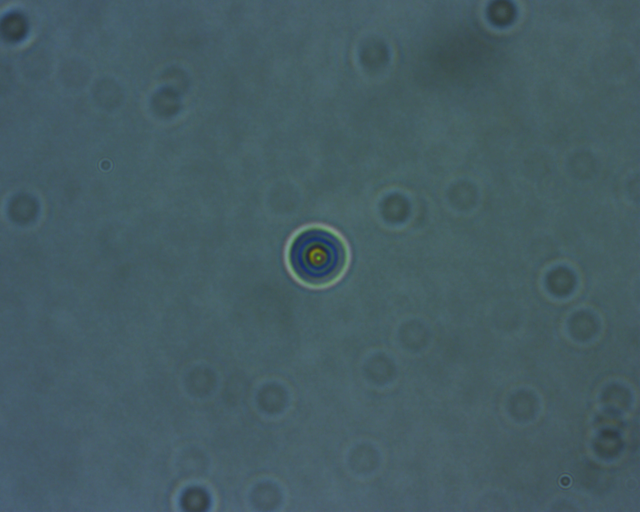

In [24]:
##### LOAD DATA

# explore files in this directory
#csvs = list_csv(directory='.',PRINT=True)   # Lists CSV files in a given directory

# 0 - 2: laser power 100
# 3 - 6: laser power 150
# 7 - 8: laser power 200
# 9 - 10: laser power 250
# 11: laser power 300

# which data?

#100--- 2
#150--- 6
#200--- 8
#250--- 10
#300--- 11

########################################### IMG 
print("\nHere is an image from the trap")
img = Image.open("TRP_free.tif")
scale = 0.5
img = img.resize((int(img.size[0]*scale),int(img.size[1]*scale)))

display(img)

InitiateFilesPos()

<a id='main'></a>

Data set under consideration: TRP_free_100.csv


100%|██████████| 2/2 [00:00<00:00,  4.68it/s]

0 0
[10.0, 100.0]
[2.4527950456612943e-15, 7.358385136983882e-15]
1.68e-08 1.380649e-23 3.141592653589793 8.674014916834654e-06
[3.67658378e-18 3.67658373e-18 3.67658368e-18 ... 9.97992491e-24
 9.95514478e-24 9.93042619e-24]
0 1
100.0
2.452795045661294e-11
1.68e-08 1.380649e-23 3.141592653589793 8.674014916834654e-06
[3.67658378e-18 3.67658373e-18 3.67658368e-18 ... 9.97992491e-24
 9.95514478e-24 9.93042619e-24]


Data set under consideration: TRP_free_150.csv


100%|██████████| 2/2 [00:00<00:00,  6.10it/s]

1 0
[60, 100.0]
[1e-15, 9e-15]
1.68e-08 1.380649e-23 3.141592653589793 1.0545544521287804e-05
[2.48741134e-18 2.48741131e-18 2.48741129e-18 ... 9.97991196e-24
 9.95513190e-24 9.93041336e-24]
1 1
100.0
2.452795045661294e-16
1.68e-08 1.380649e-23 3.141592653589793 1.0545544521287804e-05
[2.48741134e-18 2.48741131e-18 2.48741129e-18 ... 9.97991196e-24
 9.95513190e-24 9.93041336e-24]


Data set under consideration: TRP_free_200.csv


100%|██████████| 2/2 [00:00<00:00,  3.98it/s]

2 0
[77, 100.0]
[3.85e-15, 4.2e-15]
1.68e-08 1.380649e-23 3.141592653589793 1.5285615229700898e-05
[1.18391547e-18 1.18391546e-18 1.18391546e-18 ... 9.97986787e-24
 9.95508803e-24 9.93036971e-24]
2 1
[60, 90]
[2.9e-16, 3.3e-16]
1.68e-08 1.380649e-23 3.141592653589793 1.5285615229700898e-05
[1.18391547e-18 1.18391546e-18 1.18391546e-18 ... 9.97986787e-24
 9.95508803e-24 9.93036971e-24]


Data set under consideration: TRP_free_250.csv


100%|██████████| 2/2 [00:00<00:00,  5.96it/s]

3 0
[80, 140]
[4e-15, 5e-15]
1.68e-08 1.380649e-23 3.141592653589793 1.3364013549659456e-05
[1.54886109e-18 1.54886109e-18 1.54886108e-18 ... 9.97988770e-24
 9.95510775e-24 9.93038934e-24]
3 1
[70, 90]
[3e-16, 3.5e-16]
1.68e-08 1.380649e-23 3.141592653589793 1.3364013549659456e-05
[1.54886109e-18 1.54886109e-18 1.54886108e-18 ... 9.97988770e-24
 9.95510775e-24 9.93038934e-24]


Data set under consideration: TRP_free_300.csv


100%|██████████| 2/2 [00:00<00:00,  6.02it/s]

4 0
[100, 140]
[4.2e-15, 6e-15]
1.68e-08 1.380649e-23 3.141592653589793 1.707574910284702e-05
[9.48696232e-19 9.48696228e-19 9.48696225e-19 ... 9.97984702e-24
 9.95506728e-24 9.93034906e-24]
4 1
[80, 110]
[3e-16, 5e-16]
1.68e-08 1.380649e-23 3.141592653589793 1.707574910284702e-05
[9.48696232e-19 9.48696228e-19 9.48696225e-19 ... 9.97984702e-24
 9.95506728e-24 9.93034906e-24]


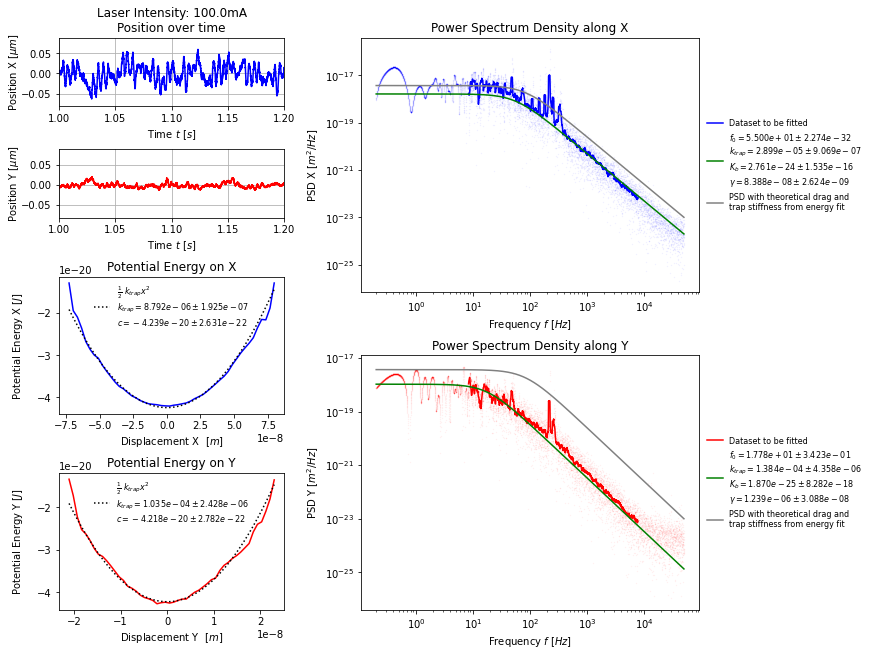

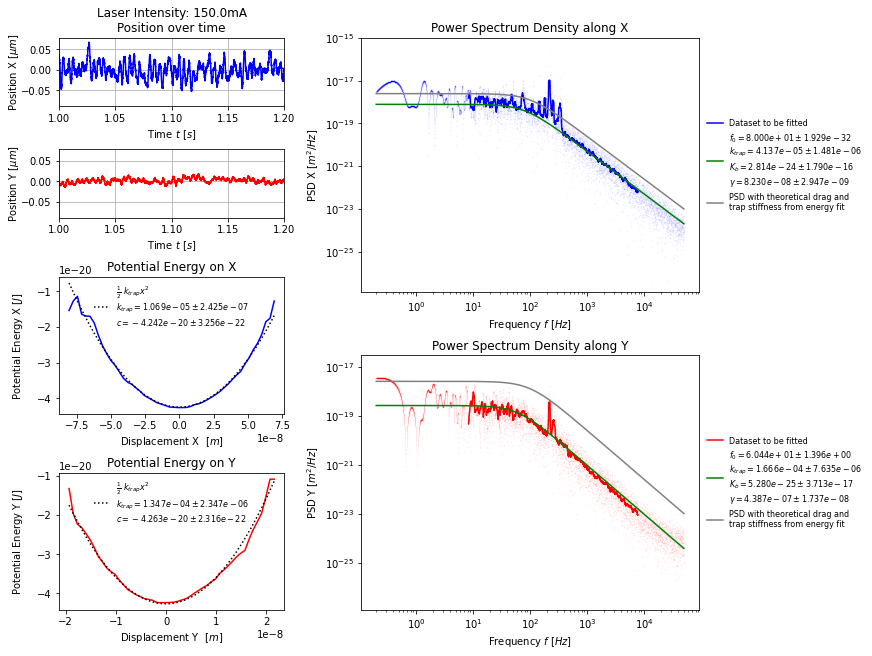

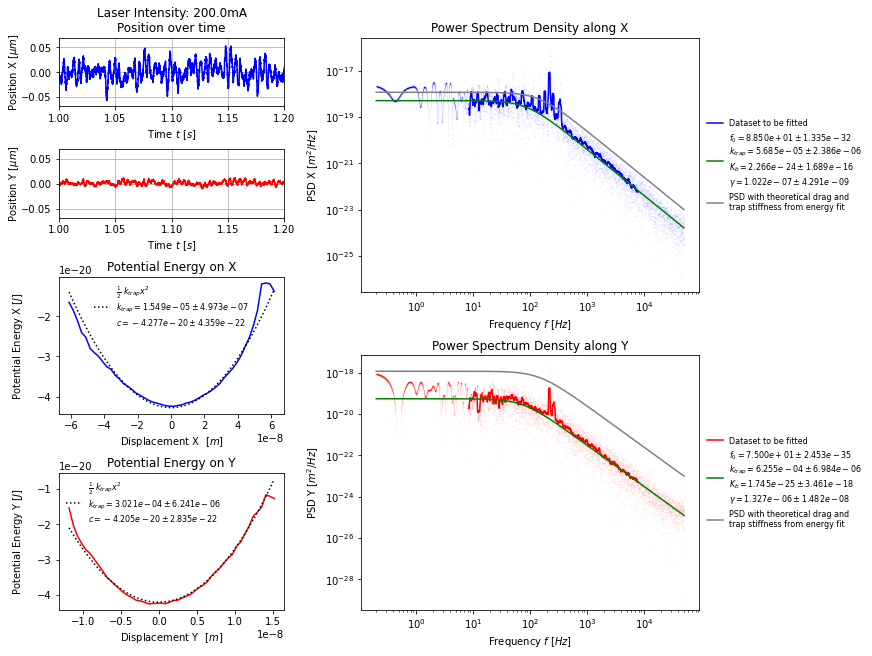

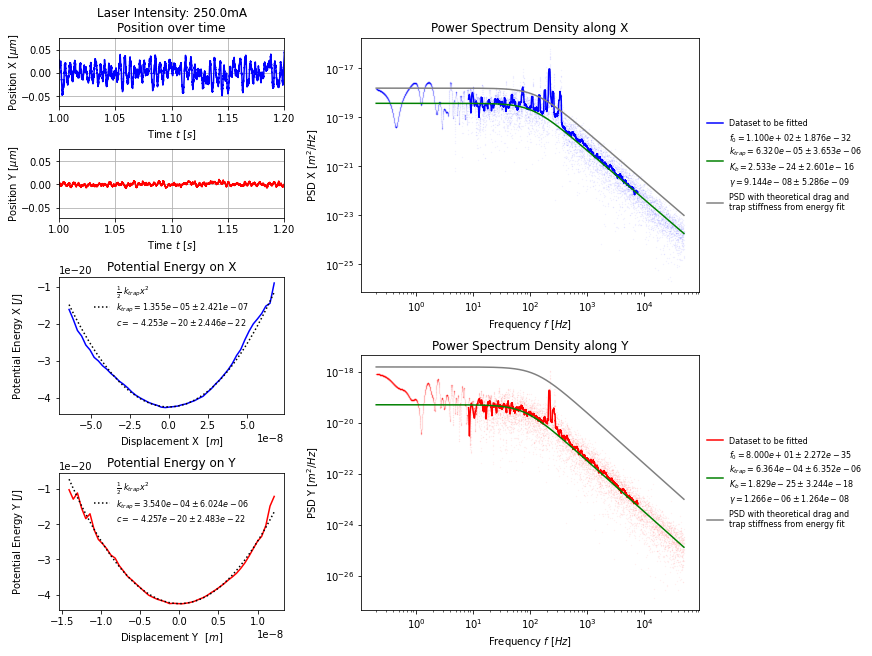

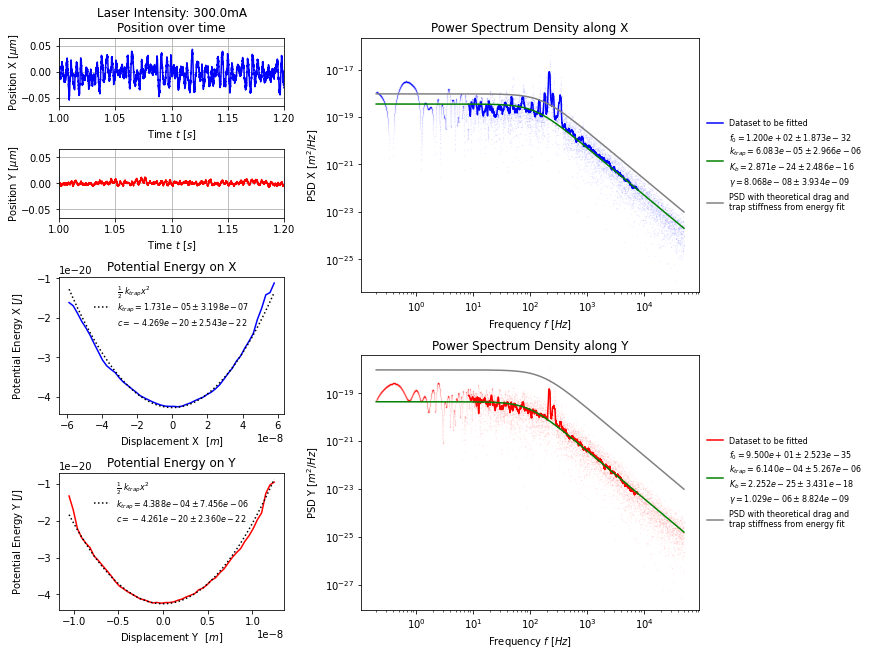

In [57]:
##### MAIN PROGRAM

files = [2,6,8,10,11]
#files = [6]

# importing QPD calibration data
cal_QPD,err_QPD,cal_alpha,err_alpha,cal_beta,err_beta,laser_intensity = ImportQPDCal()

for arr in range(0,len(files)):
    
    fig = plt.figure(figsize=(12,9),constrained_layout=True)

    gs = gridspec.GridSpec(ncols=5, nrows=6,wspace=3, figure=fig)


    #axs[0,0].set_xticklabels([])

    ax_pos_x = fig.add_subplot(gs[0,:2])
    ax_pos_y = fig.add_subplot(gs[1,:2])

    ax_pos_x.get_shared_y_axes().join(ax_pos_x, ax_pos_y)

    ax_Enrg_x = fig.add_subplot(gs[2:4,:2])
    ax_Enrg_y = fig.add_subplot(gs[4:6,:2])

    ax_PSD_x = fig.add_subplot(gs[:3,2:])
    ax_PSD_y = fig.add_subplot(gs[3:,2:])

    ax_pos = [ax_pos_x,ax_pos_y]
    ax_PSD = [ax_PSD_x,ax_PSD_y]
    ax_Enrg = [ax_Enrg_x,ax_Enrg_y]
    
    # getting data
    t,x,y,z,laser,filename = readDATA(files[arr],centerData=True,printCSV=False)
    print("Data set under consideration: "+filename)      # Print filename
    
    # determines index for laser power
    # necessary to use correct calibration data
    laser_indx = list.index(laser_intensity,laser)
    
    # initiate lists to save data
    [k_potential, err_k_potential, err_k_cov, PSD_I_k, err_PSD_I_k,
    PSD_II_drag, PSD_II_k_b, PSD_II_f0, PSD_II_k, err_PSD_II_drag, err_PSD_II_k_b, err_PSD_II_f0, err_PSD_II_k,
    PSD_III_f0, err_PSD_III_f0, PSD_III_k, err_PSD_III_k, PSD_III_drag, err_PSD_III_drag] = InitiateLists(19)
    
    # converting QPD voltage to position of stage
    x_pos = x*cal_QPD[0][laser_indx]
    y_pos = y*cal_QPD[1][laser_indx]
    
    ###############################################  Creating FIGURE: position vs time
    #fig_position = plt.figure(figsize=(10,5))
    #fig_position, ax_pos = plt.subplots(2, 1,sharey=True)
    
    # choose position or voltage
    file = 'position'
    
    # choose time frame
    start_t=1
    end_t=1.2
    
    # setting up data arrays and info
    if file == 'position':
        coords = [x_pos,y_pos]
    else:
        coords=[x,y]
        
    labels = ['X','Y']
    colors = ['b','r']
    
    for i in range(0,len(coords)):
        PlotPosition(ax_pos[i],file,labels[i],colors[i],t,coords[i],start_t,end_t,laser,title=not bool(i))
    
    # saving
    #fig_position.savefig("free_bead_"+file+'_'+str(int(laser))+".jpg",dpi=200,orientation='portrait',bbox_inches='tight')
    
    # getting PSD plots
    
    #fig_PSD = plt.figure(figsize=(15,5),tight_layout=False)
    #ax_PSD = fig_PSD.subplots(1, 2)
    
    fs = ((max(t)-min(t))/len(t))**(-1)        # sampling frequency of data collection
    
    for i in tqdm(range(0,len(coords))):
        
        ###################################### plotting POWER SPECTRUM DENSITY
        
        # Obtaining the power spectrum
        f,pxx = scipy.signal.periodogram(coords[i],fs=fs,scaling='density')

        # rescaling the data (to be equally distributed in log x)
        sample_size = 10000
        f_rescaled, pxx_rescaled = PSD_Rescale(f,pxx,sample_size)

        #moving average
        f_avg, pxx_avg = PSD_Moving_Average(f_rescaled,pxx_rescaled)

        #section to fit
        start = int(0.3*sample_size)
        end = int(0.85*sample_size)

        # region to be fitted
        f_fit = f_avg[start:end]
        pxx_fit = pxx_avg[start:end]
        
        # data to plot
        f_plot = f_rescaled
        pxx_plot = pxx_rescaled

        # Plot the power spectrum
        PlotPSD(ax_PSD[i],labels[i],colors[i],f_plot,pxx_plot,f_fit,pxx_fit,laser)
        

        ###################################### fitting POWER SPECTRUM DENSITY 
        
        # constants
        eta = 8.9e-4 #2.414e-5
        d   = 2e-6
        T = 294.15
        beta = 3*np.pi*eta*d
        
        # for x axis use bounds, for y use starting parameters
        #if i == 0: bounds = True
        #else: bounds = False
        
        guess = const.k*T/(np.pi**2*3*np.pi*eta*d)
        #################################################################################################### HERE
        bounds = False 
        # note: the ranges were chosen after trying many different values
        # for each pair of ranges, we started by fitting a large interval of values and slowly narrowing it down
        #       towards a better fit
        f0_list = [
                    [[1e1,1e2],1e2],
                    [[60,1e2],1e2],
                    [[77,1e2],[60,90]],
                    [[80,140],[70,90]],
                    [[100,140],[80,110]]
                  ]
        
        
        A0_list = [
                    [[1e-1*guess,0.3e-0*guess],1e3*guess],
                    #[[5e-16,9e-16],1e-2*guess],
                    [[1e-15,9e-15],1e-2*guess],
                    [[3.85e-15,4.2e-15],[2.9e-16,3.3e-16]],
                    [[4e-15,5e-15],[3e-16,3.5e-16]],
                    [[4.2e-15,6e-15],[3e-16,5e-16]]
                  ]
        
        
        bounds_list=[[True,False],[True,False],[True,True],[True,True],[True,True]]
        print(laser_indx,i)
        parameters = [
            [0.5e-07],
            [f0_list[laser_indx][i],A0_list[laser_indx][i]],
            [70,0.5e-4],
        ]
        
        print(f0_list[laser_indx][i])
        print(A0_list[laser_indx][i])
        
        #PSDI_Plot_Fit(ax_PSD[i],bounds,f_fit,pxx_fit,parameters[0],f_plot,pxx_plot,plot=False)
        
        PSDII_Plot_Fit(ax_PSD[i],bounds_list[laser_indx][i],f_fit,pxx_fit,parameters[1][0],parameters[1][1],f_plot,pxx_plot)
        
        #PSDIII_Plot_Fit(ax_PSD[i],bounds,f_fit,pxx_fit,parameters[2][0],parameters[2][1],f_plot,pxx_plot,plot=False)
        
        
        potential = [8.674014916834654e-06,1.0545544521287804e-05,1.5285615229700898e-05,1.3364013549659456e-05,1.707574910284702e-05]
        trap = potential[arr]
        T = 298.15
        print(gamma,const.k,np.pi,trap)
        func = lambda x,trap: (const.k*T)/((np.pi**2)*gamma*(x**2+(trap/(2*np.pi*gamma))**2))
        
        ax_PSD[i].plot(f_plot,func(f_plot,trap),color="gray",label="PSD with theoretical drag and\ntrap stiffness from energy fit")
        print(func(f_plot,trap))
        
        ax_PSD[i].legend(loc='center left', bbox_to_anchor=(1, 0.5),fontsize=sz_legend,frameon=False)
    
                                         
        
    ###################################### plotting POTENTIAL ENERGY
    
    #fig_Enrg = plt.figure(figsize=(12,5),tight_layout=False)
    #ax_Enrg = fig_Enrg.subplots(1, 2)
    
    for i in range(0,len(coords)):
    
        Nbins = 50 # binning of position data to get energy histogram
        xx,E = Energy_construct(coords[i],Nbins)
    
        PlotEnergy(ax_Enrg[i],labels[i],colors[i],xx,E)
        
        parameters = [
            1e-5, 1e-20
        ]
        
        Fit_Energy(ax_Enrg[i],xx,E,parameters)
        
        ax_Enrg[i].legend(fontsize = sz_legend,frameon=False)
    
    fig.savefig("free_bead_"+'_'+str(int(laser))+"_check"+".jpg",dpi=400,bbox_inches='tight')
    
    k_equi,err_k_equi = SolveEquipartition(coords,labels)
    
    
    
#    SaveFittedPos(laser,k_equi,err_k_equi,k_potential,err_k_potential,err_k_cov,PSD_I_k,err_PSD_I_k,
#                  PSD_II_drag,err_PSD_II_drag,PSD_II_k_b,err_PSD_II_k_b,
#                  PSD_II_f0,err_PSD_II_f0,PSD_II_k,err_PSD_II_k,PSD_III_f0,err_PSD_III_f0,PSD_III_k,
#                  err_PSD_III_k,PSD_III_drag,err_PSD_III_drag)

        

## Comparing values

In [ ]:
# t-test for Boltzmann's constant

In [5]:
#Boltzmann's constant
k_B = np.array([[2.7612e-24,2.8144e-24,2.2656e-24,2.5330e-24,2.8707e-24],
            [1.8701e-25,5.2799e-25,1.7449e-25,1.8293e-25,2.2515e-25]])
err_k = np.array([[8.64e-26,1.008e-25,9.51e-26,1.464e-25,1.400e-25],
             [4.66e-27,2.090e-26,1.95e-27,1.83e-27,1.93e-27]])

t_test = (k_B - const.k)/err_k
print(t_test)

[[ -127.83900463  -109.0485119   -121.3553102    -77.00471311
    -78.11278571]
 [-2922.63519313  -635.33492823 -6990.76923077 -7444.56830601
  -7036.96373057]]


In [11]:
#drag coefficient

drag = np.array([[8.4,8.2,10.2,9.1,8.1],
       [124,44,133,127,102.9]])
drag*=1e-8

drag_err = np.array([[0.3,0.3,0.4,0.5,0.4],
           [3,2,1,1,0.9]])
drag_err*=1e-8

gamma = 1.68e-8

t_test = (drag-gamma)/drag_err

print(t_test)

[[ 22.4         21.73333333  21.3         14.84        16.05      ]
 [ 40.77333333  21.16       131.32       125.32       112.46666667]]


In [49]:

potential = [8.674014916834654e-06,1.0545544521287804e-05,1.5285615229700898e-05,1.3364013549659456e-05,1.707574910284702e-05]

f_0_expected = np.array(potential)/(2*np.pi*gamma)
A_expected = const.k*T/(np.pi**2*gamma)

print(f_0_expected)
print(A_expected)
print(PSD_II_f0)

[ 82.17335419  99.90330584 144.80840607 126.60409619 161.76725457]
2.4826132517419625e-14
[120.0, 95.0]


In [ ]:
        trap = potential[arr]
        func = lambda x,trap: const.k*T/(np.pi**2*gamma*(x+(trap/(2*np.pi*gamma))**2))
        

In [61]:
# comparing x and y 

k_x = np.array([[8.138407078973267e-06,1.0550676266115776e-05,1.3746492285191251e-05,1.3370303795945996e-05,1.6055402799878424e-05],
       [8.674014916834654e-06,1.0545544521287804e-05,1.5285615229700898e-05,1.3364013549659456e-05,1.707574910284702e-05]])
err_k_x = np.array([[2.29565629e-07,2.69403306e-07,4.20296149e-07,3.33479303e-07,4.68412338e-07],
          [2.44673887e-07,2.69272271e-07,4.67354514e-07,3.33322413e-07,4.98180685e-07]])
k_y =np.array([[0.0001062692670735085,0.00012630097183026238,0.00032095721038298265,0.0003483230384665056,0.00041637940878113154],
       [0.00010208128111398437,0.00013285161467378024,0.00029808208716007784,0.0003492685151042814,0.0004328790737963886]])
err_k_y = np.array([[6.08529249e-06,7.21218394e-06,1.93173856e-05,1.97159019e-05,2.30514739e-05],
          [5.84547602e-06,7.58624631e-06,1.79406052e-05,1.97694181e-05,2.39649235e-05]])

t_test = np.abs((k_x-k_y)/np.sqrt(err_k_x**2+err_k_y**2))
print(t_test)

[[16.11444431 16.03808595 15.89956508 16.98653367 17.36294103]
 [15.96543177 16.11193367 15.75758252 16.98870271 17.34674896]]


In [170]:
print(3*np.pi*eta*d)

1.6776104770169493e-08


# Old code (not) useful?

In [184]:
%%script echo NOT EDITED [old version]

# fitting VOLTAGE plots [x,y,z]


###########################################  Creating FIGURE
fig = plt.figure(figsize=(20,18))

coords = [x,y,z]
labels_V = ['x','y','z']
colors = ['b','r','g']

#data to store

for i in tqdm(range(0,len(labels_V))):
    
    ####################################### plotting POSITION
    # Adding the necessary plot elements
    ax = fig.add_subplot(331+i*3)
    if i==0: ax.set_title('Position over time\n',fontsize=18)
    ax.set_xlabel(r'Time $t\ [s]$')
    ax.set_ylabel('Position ' + labels[i] + r' $ [V]$')
    ax.grid()
    
    ax.plot(t,coords[i]*1e6,c=colors[i])

    
    ###################################### plotting POWER SPECTRUM DENSITY
    # Adding the necessary plot elements
    ax = fig.add_subplot(332+i*3)
    if i==0: ax.set_title('Power Spectrum Density\n',fontsize=18)
    ax.set_xlabel(r'Frequency $f\ [Hz]$')
    ax.set_ylabel('Sxx ' + labels[i] + r' $ [V^2/Hz]$')
    ax.grid()

    # Obtaining the power spectrum
    f,pxx = scipy.signal.periodogram(coords[i],fs=fs,scaling='density')
    
    # rescaling the data (to be equally distributed in log x)
    sample_size = 10000
    
    spl = interpolate.splrep(f, pxx)
    f_new = np.exp(np.linspace(np.log(f[1]), np.log(f[-1]), sample_size))
    pxx_new = interpolate.splev(f_new, spl)
    
    # smoothing - moving average
    total = len(pxx_new)
    window = int(sample_size/100)
    
    pxx_avg = np.zeros(total-window)
    
    for k in range (total-window):
        pxx_avg[k] = np.sum(pxx_new[k:k+window])/window
    
    f_avg = f_new[:total-window]
    
    #section to fit
    start = int(0.3*sample_size)
    end = int(0.7*sample_size)
    
    # Plot the power spectrum
    ax.plot(f_new,pxx_new,'.',c=colors[i],ms=1)
    
    #cut1 = int(0.55*sample_size)
    #cut2 = int(0.65*sample_size)
    
    #f_cut = np.concatenate((f_avg[start:cut1], f_avg[cut2:end]),axis=None)
    #pxx_cut = np.concatenate((pxx_avg[start:cut1], pxx_avg[cut2:end]))
    
    # region to be fitted
    f_fit = f_avg[start:end]
    pxx_fit = pxx_avg[start:end]
    #f_fit = f_cut
    #pxx_fit = pxx_cut
    
    ax.plot(f_fit,pxx_fit,'.',c='yellow')
    
    
    ###################################### fitting POWER SPECTRUM DENSITY 
    
    method = 'III'
    
    if method == 'I':
        alpha_trap = 0.5e-14
        
        params, _ = curve_fit(SxxI,f_fit,pxx_fit,p0=[alpha_trap])
        
        PSD_I_k.append(params[0])
        #assumes theoretical drag
        
        # Plot the fit
        ax.plot(f_avg,SxxI(f_avg,*params),c='k',\
                label=r'$f_0 = %1.3e$'%(params[0]/(2*np.pi*beta))+
                '\n'+r'$\alpha = %1.3e$'%(params[0]))
    
    if method == 'II':
        A_0 = 1e-3*(const.k*T/(np.pi**2*3*np.pi*eta*d))
        #f_0 = 1e-14/(2*np.pi**2*3*eta*d)
        f_0 = 1e2
        
        params, _ = curve_fit(SxxII,f_fit,pxx_fit,p0=[f_0,A_0])
        
        k_b = params[1]*(np.pi**2*3*np.pi*eta*d)/T
        
        beta_fit = const.k*T/(np.pi**2*params[1])
        
        PSD_II_drag.append(beta_fit)
        PSD_II_k_b.append(k_b)
        PSD_II_f0.append(params[0])
        PSD_II_k.append(params[0]*(2*np.pi**2*3*eta*d))
        
        print("drag coefficient from fit", beta_fit)
        
        # Plot the fit
        ax.plot(f_avg,SxxII(f_avg,*params),c='k',\
                label=r'$f_0 = %1.3e$'%(params[0])+
                        '\n'+r'$\alpha = %1.3e$'%(params[0]*(2*np.pi**2*3*eta*d))+
                        '\n'+r'$K_b = %1.3e$'%k_b+
                        '\n'+r'$\beta = %1.3e$'%beta_fit)
        
    if method == 'III':
        
        f_0 = 70
        alpha_trap = 1e-3
        
        params, _ = curve_fit(SxxIII,f_fit,pxx_fit,p0=[f_0,alpha_trap])

        PSD_III_f0.append(params[0])
        PSD_III_k.append(params[1])
        PSD_III_drag.append(params[1]/(2*np.pi*params[0]))
        
        # Plot the fit
        ax.plot(f_avg,SxxIII(f_avg,*params),c='k',\
                label=r'$f_0 = %1.3e$'%(params[0])+
                '\n'+r'$\alpha = %1.3e$'%(params[1])+
                '\n'+r'$\beta = %1.3e$'%(params[1]/(2*np.pi*params[0]))+
                '\n'+r'$\eta = %1.3e$'%((params[1]/(2*np.pi*params[0]))/(3*d*np.pi)))
        
    ax.set_xscale('log')
    ax.set_yscale('log')
    ax.set_ylim(1e-25,1e-12)
    ax.legend()

    ###################################### plotting POTENTIAL ENERGY
    
    # Adding the necessary plot elements
    ax = fig.add_subplot(333+i*3)
    if i==0: ax.set_title('Potential Energy\n',fontsize=18)
    ax.set_xlabel('Displacement '+labels[i]+r' $f\ [m]$')
    ax.set_ylabel('Ptential Energy ' + labels[i] + r' $ [J]$')
    ax.grid()

    # Obtaining the histogram of the data
    hist, xx = np.histogram(coords[i],bins=Nbins)
    xx = np.array([(xx[i]+xx[i+1])/2 for i in range(len(xx)-1)])
    
    # Finding energy
    E = -const.k*T*np.log(hist)

    # Plot the potential energy
    ax.plot(xx,E,c=colors[i])
    
    # Obtaining the best fit curve for the histogram
    #params = np.polyfit(xx,E, 2)
    params, _ = curve_fit(poly,xx,E,p0=[1e-5,1e-10,1e-20])
    ax.plot(xx,poly(xx,*params),ls=':',c='k',
            label=r'$ %1.3e (x + %1.3e)^2  % 1.3e  $'%tuple(params)) 
    k_potential.append(params[0])
    ax.set_ylim(-0.5e-19,0)
    ax.legend()


plt.show()

NOT EDITED


In [767]:
%%script echo NOT EDITED [old version]

# defining fitting functions

########################################### FIT FUNCTIONS

# constants
eta = 8.9e-4 #2.414e-5
d   = 2e-6
T = 294.15
beta = 3*np.pi*eta*d

print("Theoretical drag coefficient ", beta)

# to fit PSD
SxxI = lambda f,alpha: (const.k*T)/(np.pi**2 * beta*(f**2 + (alpha/(2*np.pi*beta))**2))
SxxII = lambda f,f_0,alpha: alpha/(f**2+f_0**2)
SxxIII = lambda f,f_0,alpha: (2.*const.k*T*f_0)/(np.pi*alpha*(f**2+f_0**2))

##### Description of functions
# Sxx: assumes theoretical drag coefficient; one fit parameter - trap stiffness
# SxxII: two fit parameters - the cutoff frequency and drag coefficient;
#        can calculate Boltzmann's constant experimentally by assuming theoretical drag
# SxxIII: two fit parameters - cutoff frequency and trap stiffness

# to fit energy
poly = lambda x,a,b,c: a*(x+b)**2+c
polyII = lambda x,a,c : a*x**2+c

# to calculate PSD
fs = ((max(t)-min(t))/len(t))**(-1)        # sampling frequency of data collection
Nbins = 60                                 # binning of position data to get energy histogram

NOT EDITED [old version]


In [768]:
%%script echo NOT EDITED [old version]

for i in tqdm(range(0,len(coords))):
    
    ###################################### plotting POWER SPECTRUM DENSITY
    # Adding the necessary plot elements
    ax = fig.add_subplot(332+i*3)
    if i==0: ax.set_title('Power Spectrum Density\n',fontsize=18)
    ax.set_xlabel(r'Frequency $f\ [Hz]$')
    ax.set_ylabel('Sxx ' + labels[i] + r' $ [m^2/Hz]$')
    ax.grid()

    # Obtaining the power spectrum
    f,pxx = scipy.signal.periodogram(coords[i],fs=fs,scaling='density')
    
    # rescaling the data (to be equally distributed in log x)
    sample_size = 10000
    
    spl = interpolate.splrep(f, pxx)
    f_new = np.exp(np.linspace(np.log(f[1]), np.log(f[-1]), sample_size))
    pxx_new = interpolate.splev(f_new, spl)
    
    #moving average
    total = len(pxx_new)
    window = int(sample_size/100)
    
    pxx_avg = np.zeros(total-window)
    
    for k in range (total-window):
        pxx_avg[k] = np.sum(pxx_new[k:k+window])/window
    
    f_avg = f_new[:total-window]
    
    #section to fit
    start = int(0.3*sample_size)
    end = int(1*sample_size)
    
    # Plot the power spectrum
    ax.plot(f_new,pxx_new,'.',c=colors[i],ms=1)
    
    # region to be fitted
    f_fit = f_avg[start:end]
    pxx_fit = pxx_avg[start:end]
    
    ax.plot(f_fit,pxx_fit,'.',c='yellow')
    
    
    ###################################### fitting POWER SPECTRUM DENSITY 
    
    method = 'II'
    
    if method == 'I':
        alpha_trap = 0.5e-7
        
        params, pcov = curve_fit(SxxI,f_fit,pxx_fit,p0=[alpha_trap], maxfev=1000)
        
        PSD_I_k.append(params[0])
        err_PSD_I_k.append(pcov[0])
        #assumes theoretical drag
        
        # Plot the fit
        ax.plot(f_new,SxxI(f_new,*params),c='k',\
                label=r'$f_0 = %1.3e \pm %1.3e$'%(params[0]/(2*np.pi*beta),pcov[0])+
                '\n'+r'$\alpha = %1.3e \pm %1.3e$'%(params[0],pcov[0]))
    
    if method == 'II':
        A_0 = 1e-3*(const.k*T/(np.pi**2*3*np.pi*eta*d))
        #f_0 = 1e-14/(2*np.pi**2*3*eta*d)
        f_0 = 1e2
        
        if i == 0: 
            params, pcov = curve_fit(SxxII,f_fit,pxx_fit,bounds=tuple([[80,A_0*1e2],[130,A_0*0.5e3]]),maxfev=1000) 
        else:
            params, pcov = curve_fit(SxxII,f_fit,pxx_fit,p0=[f_0,A_0],maxfev=1000)
        
        f0 = params[0]
        A0 = params[1]
        
        err_f0 = np.sqrt(pcov[0][0])
        err_A0 = np.sqrt(pcov[1][1])
        
        k_b_th = A0*(np.pi**2*3*np.pi*eta*d)/T
        
        beta_fit = const.k*T/(np.pi**2*A0)
        err_beta_fit = beta_fit * err_A0/A0
        
        alpha_th = f0*(2*np.pi**2*3*eta*d)
        
        alpha_exp = f0*(2*np.pi*beta_fit)
        err_alpha_exp = np.sqrt((err_f0/(2*np.pi*beta_fit))**2+(alpha_exp*err_beta_fit/beta_fit)**2)
        
        PSD_II_drag.append(beta_fit)
        PSD_II_k_b.append(k_b_th)
        PSD_II_f0.append(f0)
        PSD_II_k.append(alpha_exp)
        
        err_PSD_II_drag.append(err_beta_fit)
        err_PSD_II_k_b.append(err_k_b_th)
        err_PSD_II_f0.append(err_f0)
        err_PSD_II_k.append(err_alpha_exp)
        
        print("drag coefficient from fit", beta_fit)
        
        # Plot the fit
        ax.plot(f_new,SxxII(f_new,*params),c='k',\
                label=r'$f_0 = %1.3e \pm %1.3e$'%(f0,err_f0)+
                        '\n'+r'$\alpha_{th} = %1.3e \pm %1.3e$'%(alpha_th,err_f0)+
                        '\n'+r'$\alpha_{exp} = %1.3e \pm %1.3e$'%(alpha_exp,err_alpha_exp)+
                        '\n'+r'$K_b = %1.3e \pm %1.3e$'%(k_b_th,err_A0)+
                        '\n'+r'$\beta_{exp} = %1.3e \pm% 1.3e$'%(beta_fit,err_beta_fit))
        
    if method == 'III':
        
        f_0 = 70
        alpha_trap = 0.5e-4
        
        if i == 0:
            params, pcov = curve_fit(SxxIII,f_fit,pxx_fit,bounds=tuple([[80,9.5e-06],[130,5e-05]]),maxfev=100000) #
        else: 
            params, pcov = curve_fit(SxxIII,f_fit,pxx_fit,p0=[f_0,alpha_trap],maxfev=100000) #bounds=tuple([[50,1e-06],[200,1e-03]])

        f0 = params[0]
        alpha_trap = params[1]
        
        err_f0 = np.sqrt(pcov[0][0])
        err_alpha_trap = np.sqrt(pcov[1][1])
        
        beta_exp = alpha_trap/(2*np.pi*f0)
        err_beta_exp = np.sqrt((err_alpha_trap/(2*np.pi*f0))**2+(beta_exp*err_f0/f0)**2)
        
        eta = beta_exp / (3*d*np.pi)
        
        
        PSD_III_f0.append(params[0])
        PSD_III_k.append(params[1])
        PSD_III_drag.append(params[1]/(2*np.pi*params[0]))
        
        # Plot the fit
        ax.plot(f_new,SxxIII(f_new,*params),c='k',\
                label=r'$f_0 = %1.3e \pm %1.3e$'%(f0,err_f0)+
                '\n'+r'$\alpha_{trap} = %1.3e \pm %1.3e$'%(alpha_trap,err_alpha_trap)+
                '\n'+r'$\beta = %1.3e \pm %1.3e$'%(beta_exp,err_beta_exp)+
                '\n'+r'$\eta = %1.3e \pm %1.3e$'%(eta,err_beta_exp))
        
    ax.set_xscale('log')
    ax.set_yscale('log')
    #ax.set_ylim(1e-25,1e-12)
    ax.legend()

    ###################################### plotting POTENTIAL ENERGY
    
    # Adding the necessary plot elements
    ax = fig.add_subplot(333+i*3)
    if i==0: ax.set_title('Potential Energy\n',fontsize=18)
    ax.set_xlabel('Displacement '+labels[i]+r' $f\ [m]$')
    ax.set_ylabel('Ptential Energy ' + labels[i] + r' $ [J]$')
    ax.grid()

    # Obtaining the histogram of the data
    hist, xx = np.histogram(coords[i],bins=Nbins)
    xx = np.array([(xx[i]+xx[i+1])/2 for i in range(len(xx)-1)])
    
    # Finding energy
    E = -const.k*T*np.log(hist)

    # Plot the potential energy
    ax.plot(xx,E,c=colors[i])
    
    # Obtaining the best fit curve for the histogram
    #params = np.polyfit(xx,E, 2)
    params, pcov = curve_fit(polyII,xx,E,p0=[1e-5,1e-20])
    
    trap = 2*params[0]
    err_trap = np.sqrt(pcov[0][0])*2
    
    
    ax.plot(xx,polyII(xx,*params),ls=':',c='k',
            label=r'$ \frac{1}{2}\ k_{trap} x^2  + c  $'+
                '\n'+r'$ k_{trap}=%1.3e \pm %1.3e $'%tuple([trap,err_trap]) +
                '\n'+r'$ c = %1.3e \pm %1.3e$'%tuple([params[1],np.sqrt(pcov[1][1])])
           ) 
    k_potential.append(trap)

    err_k_potential.append( 2*k_potential[i]*np.sqrt((err_alpha[i][laser_indx]/cal_alpha[i][[laser_indx]])**2 + 
                                           (err_beta[i]/cal_beta[i])**2) )
    err_k_cov.append(err_trap)
    
    #ax.set_ylim(-0.5e-19,0)
    ax.legend()



fig.savefig("free_bead_"+str(int(laser))+"_"+method+".jpg")
plt.show()

NOT EDITED [old version]


In [769]:
%%script echo NOT EDITED [old version]

############ getting data

x = data[0]
y = data[1]
z = data[2]

# converting to position for x and y

x_pos = x*cal_QPD[0][laser_indx]
y_pos = y*cal_QPD[1][laser_indx]

# Set up figure
fig = plt.figure(figsize=(16,18))

unit = [1e6,1e6,1] # plot position in um

coords = [x_pos,y_pos,z]
labels = ['x','y','z']

for i in range(len(coords)):
    ax = fig.add_subplot(311+i)
    if i==0: ax.set_title('Position over time\n',fontsize=18)
    ax.set_xlabel(r'Time $t\ [s]$')
    ax.set_ylabel('Position ' + labels[i] + r' $ [\mu m]$')
    
    if i > 1:
        ax.set_ylabel('Position ' + labels[i] + r' $ [V]$')
    
    ax.grid()

    ax.plot(t,coords[i]*unit[i],c='C%d'%(i+7))
    ax.set_xlim(0,5)

# calculating variance 

# find average; for each point calculate (x-avg)^2; sum it up

variance= []

for i in range (len(coords)):
    avg = sum(coords[i])/len(coords[i])
    var = sum((coords[i]-avg)**2)/len(coords[i])
    print("Variance of ",labels[i]," is ",var)
    
    variance.append(var) 
    
    

var_i = np.array(variance)

k_equi = const.k*T/var_i

# finding errors

err_k_equi = []
for i in range(2):
    err_k_equi.append( 2*k_equi[i]*np.sqrt((err_alpha[i][laser_indx]/cal_alpha[i][[laser_indx]])**2 + 
                                           (err_beta[i]/cal_beta[i])**2) )

print(k_equi)
print(err_k_equi)

NOT EDITED [old version]
